Let's say there is a box of dimension 1m*1m which resembles as a room in our toy problem. There's a hole of size 0.016m-0.025m in the middle of the left boundary as a window. Through this hole or window, pollutants are injected as waves. We have taken step function and gaussian pulse as waves.

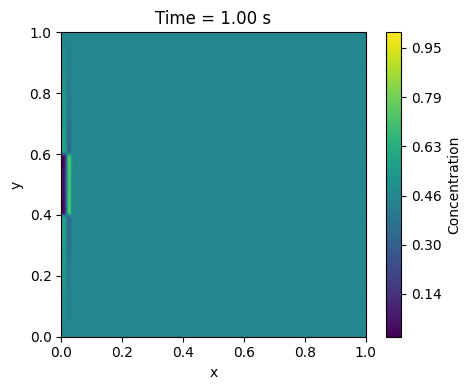

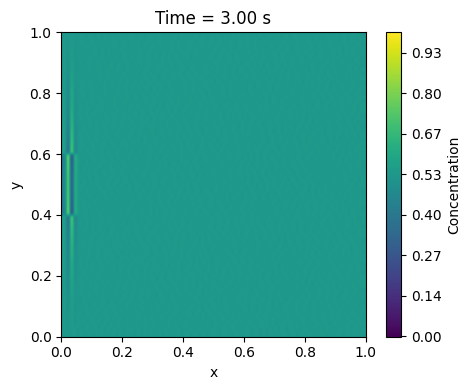

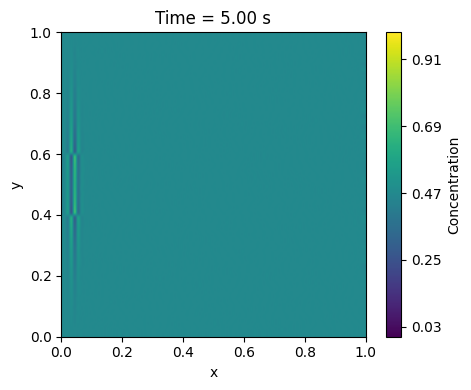

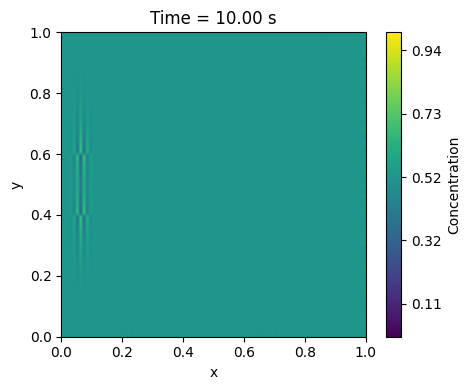

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import matplotlib.ticker as mticker
import matplotlib.animation as animation
from matplotlib.colors import Normalize
from matplotlib.animation import FuncAnimation, PillowWriter
import os

#Grid
nx,ny=100,100
lx,ly=1,1
dx,dy=lx/nx,ly/ny
dt=1
nt=15

#parameters
D=0.5  #diffusion constant
u=1   #max advection velocity
f=1    #frequency of periodic flow

#concentration
C= 0.5 * np.random.rand(nx, ny)
np.save('initial_C.npy', C)

#Crank-Nicolson coeffs
rx=D*dt/(2*dx**2)
ry=D*dt/(2*dy**2)
main_d_x= (1+2*rx)*np.ones(nx-2)
off_d_x=  -rx * np.ones(nx-3)
Ax=diags([off_d_x,main_d_x,off_d_x],offsets=[-1,0,1],format='csc')
main_d_y= (1+2*ry)*np.ones(nx-2)
off_d_y=  -ry * np.ones(nx-3)
Ay=diags([off_d_y,main_d_y,off_d_y],offsets=[-1,0,1],format='csc')

save_times = [1.0, 3.0, 5.0, 10.0]
save_index = 0

# create directory to save plots
os.makedirs('frames', exist_ok=True)

#simulation
for n in range(nt):
    t=n*dt
    cn=C.copy()

    #hole in the boundary
    j_start=ny//2-10
    j_end=ny//2+10

    # when step function is injected through the hole
    t_dur=5
    A=50
    if t<t_dur:
        C[0,j_start:j_end]=A
    else:
        C[0,j_start:j_end]=0

    cn=C.copy()

    #advection (horizontal flow) in upwind
    for i in range(1,nx):
        for j in range(1,ny-1):
            adv=-u*(cn[i,j]-cn[i-1,j])/dx
            C[i,j]+=adv*dt

    #crank nicolson for diffusion in x
    for j in range(1,ny-1):
        rhs_x=C[1:-1,j]+ rx*(C[2:,j]-2*C[1:-1,j]+C[0:-2,j])
        C[1:-1,j]=spsolve(Ax,rhs_x)

    #crank nicolson for diffusion in y
    for i in range(1,nx-1):
        rhs_y=C[i,1:-1]+ ry*(C[i,2:]-2*C[i,1:-1]+C[i,0:-2])
        C[i,1:-1]=spsolve(Ay,rhs_y)

    #Neumann BCs (no flux)
    C[0, :] = C[1, :]
    C[-1, :] = C[-2, :]
    C[:, 0] = C[:, 1]
    C[:, -1] = C[:, -2]

    # save plots at selected times
    if any(np.isclose(t, s, atol=0.5 * dt) for s in save_times):
        vmin = np.min(C)
        vmax = np.max(C)
        plt.figure(figsize=(5, 4))
        im = plt.imshow(C.T, origin='lower', extent=[0, lx, 0, ly],
                        cmap='viridis', interpolation='bicubic',
                        vmin=vmin, vmax=vmax)
        plt.title(f"Time = {t:.2f} s")
        plt.xlabel('x')
        plt.ylabel('y')

        cbar = plt.colorbar(im)
        cbar.set_label('Concentration')

        def normalize_tick(x, pos):
            return f"{(x - vmin) / (vmax - vmin):.2f}"

        cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(normalize_tick))

        plt.tight_layout()
        plt.savefig(f"frames/frame_{n:03d}.png")
        plt.show()

        save_index += 1

The initial concentration is taken random numbers. Then step function is injected as pollutant through the hole in boundary for 5s. The concentration map at time steps shows how the pollutants are spreading over the concentration field.

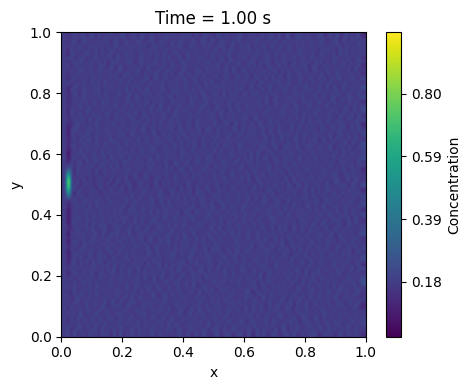

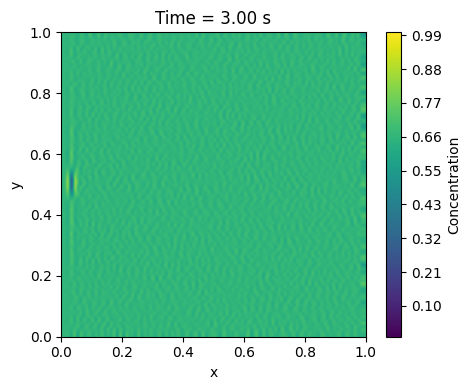

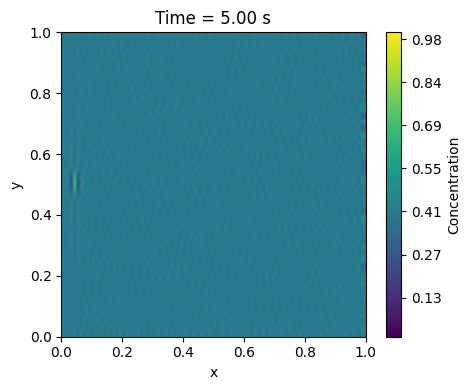

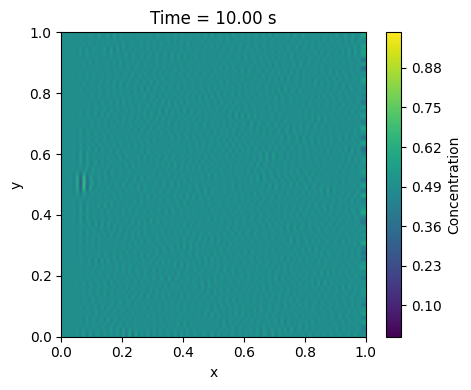

In [31]:
#when gaussian pulse is injected through the hole
C1=np.load('initial_C.npy')

# create directory to save plots
os.makedirs('frames', exist_ok=True)

# Simulation
y = np.linspace(0, ly, ny)
j_start = ny // 2 - 10
j_end = ny // 2 + 10
y0 = (y[j_start] + y[j_end]) / 2  # center of the hole
sigma = 0.03
# Gaussian pulse through boundary hole
A = 10
pulse = A * np.exp(-((y[j_start:j_end] - y0) ** 2) / (2 * sigma**2))
C1[0, j_start:j_end] = pulse

for n in range(nt):
    t = n * dt
    cn1 = C1.copy()

    # Advection (upwind in x)
    for i in range(1, nx):
        for j in range(1, ny - 1):
            adv = -u * (cn1[i, j] - cn1[i - 1, j]) / dx
            C1[i, j] += adv * dt


    # Diffusion (Crank-Nicolson in x)
    for j in range(1, ny - 1):
        rhs_x = C1[1:-1, j] + rx * (C1[2:, j] - 2 * C1[1:-1, j] + C1[0:-2, j])
        C1[1:-1, j] = spsolve(Ax, rhs_x)

    # Diffusion (Crank-Nicolson in y)
    for i in range(1, nx - 1):
        rhs_y = C1[i, 1:-1] + ry * (C1[i, 2:] - 2 * C1[i, 1:-1] + C1[i, 0:-2])
        C1[i, 1:-1] = spsolve(Ay, rhs_y)

    # Neumann boundary conditions (no flux)
    C1[0, :] = C1[1, :]
    C1[-1, :] = C1[-2, :]
    C1[:, 0] = C1[:, 1]
    C1[:, -1] = C1[:, -2]

     # save plots at selected times
    if any(np.isclose(t, s, atol=0.5 * dt) for s in save_times):
        vmin = np.min(C1)
        vmax = np.max(C1)
        plt.figure(figsize=(5, 4))
        im = plt.imshow(C1.T, origin='lower', extent=[0, lx, 0, ly],
                        cmap='viridis', interpolation='bicubic',
                        vmin=vmin, vmax=vmax)
        plt.title(f"Time = {t:.2f} s")
        plt.xlabel('x')
        plt.ylabel('y')

        cbar = plt.colorbar(im)
        cbar.set_label('Concentration')

        def normalize_tick(x, pos):
            return f"{(x - vmin) / (vmax - vmin):.2f}"

        cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(normalize_tick))

        plt.tight_layout()
        plt.savefig(f"frames/framegauss_{n:03d}.png")
        plt.show()

        save_index += 1


The initial concentration is taken same as before. Then gaussian pulse is injected as pollutant through the hole in boundary. The concentration map at time steps shows how the pollutants are spreading over the concentration field.

Let's increase the size of hole or window and see the impacts.

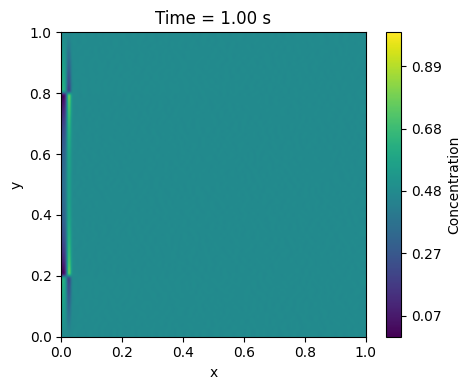

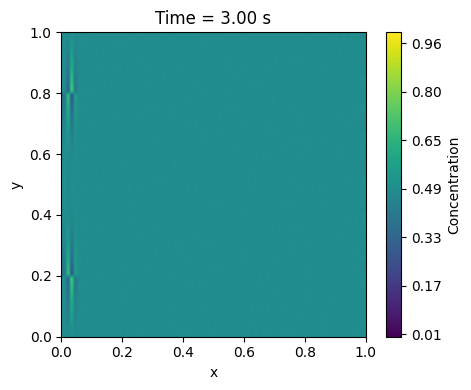

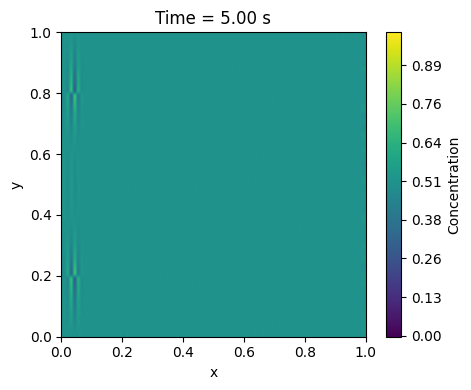

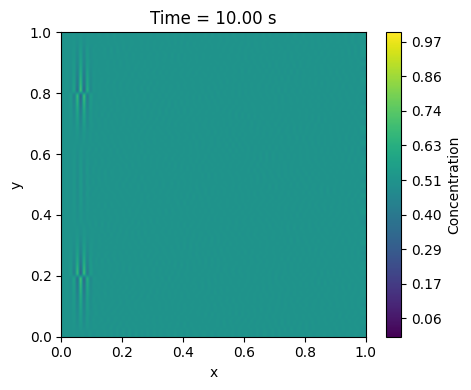

In [32]:
#for step function
c1=np.load('initial_C.npy')

for n in range(nt):
    t=n*dt
    #hole in the boundary
    j1_start=ny//2-30
    j1_end=ny//2+30

    # when step function is injected through the hole
    t_dur=5
    A=50
    if t<t_dur:
        c1[0,j1_start:j1_end]=A
    else:
        c1[0,j1_start:j1_end]=0
    cn2=c1.copy()

    #advection (horizontal flow) in upwind
    for i in range(1,nx):
        for j in range(1,ny-1):
            adv=-u*(cn2[i,j]-cn2[i-1,j])/dx
            c1[i,j]+=adv*dt

    #crank nicolson for diffusion in x
    for j in range(1,ny-1):
        rhs_x=c1[1:-1,j]+ rx*(c1[2:,j]-2*c1[1:-1,j]+c1[0:-2,j])
        c1[1:-1,j]=spsolve(Ax,rhs_x)

    #crank nicolson for diffusion in y
    for i in range(1,nx-1):
        rhs_y=c1[i,1:-1]+ ry*(c1[i,2:]-2*c1[i,1:-1]+c1[i,0:-2])
        c1[i,1:-1]=spsolve(Ay,rhs_y)

    #Neumann BCs (no flux)
    c1[0, :] = c1[1, :]
    c1[-1, :] = c1[-2, :]
    c1[:, 0] = c1[:, 1]
    c1[:, -1] = c1[:, -2]

    # save plots at selected times
    if any(np.isclose(t, s, atol=0.5 * dt) for s in save_times):
        vmin = np.min(c1)
        vmax = np.max(c1)
        plt.figure(figsize=(5, 4))
        im = plt.imshow(c1.T, origin='lower', extent=[0, lx, 0, ly],
                        cmap='viridis', interpolation='bicubic',
                        vmin=vmin, vmax=vmax)
        plt.title(f"Time = {t:.2f} s")
        plt.xlabel('x')
        plt.ylabel('y')

        cbar = plt.colorbar(im)
        cbar.set_label('Concentration')

        def normalize_tick(x, pos):
            return f"{(x - vmin) / (vmax - vmin):.2f}"

        cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(normalize_tick))

        plt.tight_layout()
        plt.savefig(f"frames/framebw_{n:03d}.png")
        plt.show()

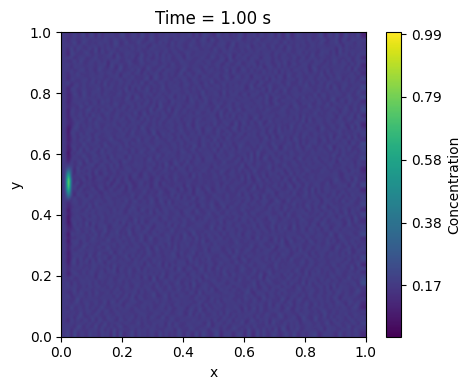

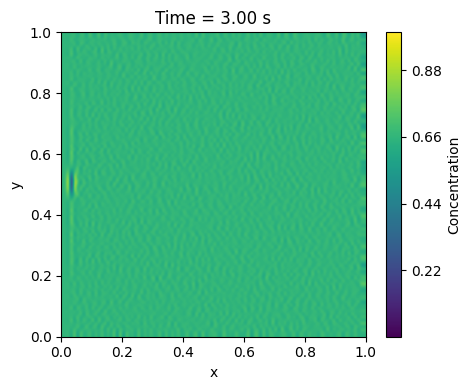

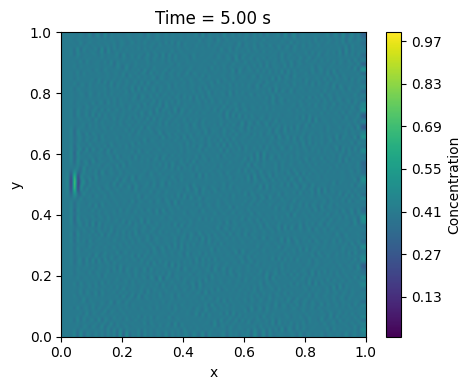

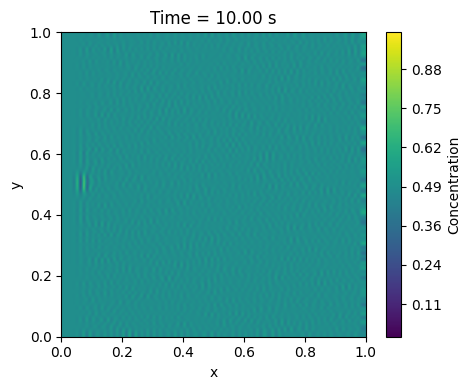

In [33]:
#for gaussian pulse
#for step function
cg1=np.load('initial_C.npy')
y = np.linspace(0, ly, ny)
j1_start = ny // 2 - 30
j1_end = ny // 2 + 30
y01 = (y[j1_start] + y[j1_end]) / 2  # center of the hole
sigma = 0.03
# Gaussian pulse through boundary hole
A = 10
pulse1 = A * np.exp(-((y[j1_start:j1_end] - y01) ** 2) / (2 * sigma**2))
cg1[0, j1_start:j1_end] = pulse1

for n in range(nt):
    t=n*dt
    cgn2=cg1.copy()
    #advection (horizontal flow) in upwind
    for i in range(1,nx):
        for j in range(1,ny-1):
            adv=-u*(cgn2[i,j]-cgn2[i-1,j])/dx
            cg1[i,j]+=adv*dt

    #crank nicolson for diffusion in x
    for j in range(1,ny-1):
        rhs_x=cg1[1:-1,j]+ rx*(cg1[2:,j]-2*cg1[1:-1,j]+cg1[0:-2,j])
        cg1[1:-1,j]=spsolve(Ax,rhs_x)

    #crank nicolson for diffusion in y
    for i in range(1,nx-1):
        rhs_y=cg1[i,1:-1]+ ry*(cg1[i,2:]-2*cg1[i,1:-1]+cg1[i,0:-2])
        cg1[i,1:-1]=spsolve(Ay,rhs_y)

    #Neumann BCs (no flux)
    cg1[0, :] = cg1[1, :]
    cg1[-1, :] = cg1[-2, :]
    cg1[:, 0] = cg1[:, 1]
    cg1[:, -1] = cg1[:, -2]

    # save plots at selected times
    if any(np.isclose(t, s, atol=0.5 * dt) for s in save_times):
        vmin = np.min(cg1)
        vmax = np.max(cg1)
        plt.figure(figsize=(5, 4))
        im = plt.imshow(cg1.T, origin='lower', extent=[0, lx, 0, ly],
                        cmap='viridis', interpolation='bicubic',
                        vmin=vmin, vmax=vmax)
        plt.title(f"Time = {t:.2f} s")
        plt.xlabel('x')
        plt.ylabel('y')

        cbar = plt.colorbar(im)
        cbar.set_label('Concentration')

        def normalize_tick(x, pos):
            return f"{(x - vmin) / (vmax - vmin):.2f}"

        cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(normalize_tick))

        plt.tight_layout()
        plt.savefig(f"frames/framebwg_{n:03d}.png")
        plt.show()